# 4.1.1 TE Network Properties

In [ ]:
import glob
import os
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from analysis.roi_utils import auto_detect_groups

In [ ]:
def plot_te_heatmaps(results_folder='results', type='TE', figsize=(5, 3), output_pdf=None):
    """
    Plot TE matrices for all conditions with consistent coloring and functional boundaries
    Now arranged in 5 columns per row
    
    Parameters:
        results_folder (str): Path containing .pkl result files
        figsize (tuple): Figure size (width, height)
        output_pdf (str): Optional path to save PDF output
    """
    
    # Set global font sizes
    plt.rcParams.update({
        'axes.titlesize': 14,    # Title size for each subplot
        'axes.labelsize': 12,    # X and Y label sizes
        'xtick.labelsize': 10,   # X tick labels
        'ytick.labelsize': 10,   # Y tick labels
        'legend.fontsize': 12,   # Legend font size
        'figure.titlesize': 16   # Overall figure title size
    })
    
    # Load all data
    result_files = sorted(glob.glob(os.path.join(results_folder, '*.pkl')))
    conditions = []
    matrices = []
    max_te_values = []
    roi_names = None
    
    for filepath in result_files:
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        cond = data.get('metadata', {}).get('selected_conditions', os.path.basename(filepath))
        if isinstance(cond, list) and len(cond) == 1:
            cond = cond[0]
        
        # Build TE matrix
        if roi_names is None:
            roi_names = data['metadata']['roi_names']
            n_rois = len(roi_names)
            groups = auto_detect_groups(roi_names)
            unique_groups = sorted(set(groups.values()))
        
        te_matrix = np.zeros((n_rois, n_rois))
        for cond_key in data['conditions']:
            for pair_data in data['conditions'][cond_key]['roi_pairs'].values():
                if 'error' in pair_data:
                    continue
                src, tgt = pair_data['roi_info']['indices']
                te_matrix[src, tgt] = pair_data.get(type, {}).get('mean', 0)
        
        conditions.append(cond)
        matrices.append(te_matrix)
        max_te_values.append(np.max(te_matrix))
    
    # Find Rest condition's max TE value
    rest_max_te = None
    for cond, te in zip(conditions, max_te_values):
        if isinstance(cond, str) and cond.lower() == 'rest':
            rest_max_te = te
            break
    
    # Sort conditions to put "Rest" first, then alphabetically
    def sort_key(cond):
        if isinstance(cond, str) and cond.lower() == 'rest':
            return (0, cond)  # Rest comes first
        return (1, cond)     # All other conditions follow
    
    # Zip, sort, and unzip
    combined = list(zip(conditions, matrices, max_te_values))
    combined.sort(key=lambda x: sort_key(x[0]))
    conditions, matrices, max_te_values = zip(*combined)
    conditions = list(conditions)
    matrices = list(matrices)
    max_te_values = list(max_te_values)
    
    # Create bar plot of max TE values
    plt.figure(figsize=(8, 5))
    barplot = sns.barplot(x=conditions, y=max_te_values, palette='viridis')
    plt.axhline(y=rest_max_te, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

    # Add value labels to each bar
    for i, (cond, value) in enumerate(zip(conditions, max_te_values)):
        barplot.text(i, value/2, f'{value:.3f}', 
                    ha='center', va='center', 
                    color='white', fontsize=10, fontweight='bold')
    
    # Customize bar plot
    # plt.title('Maximum TE Values by Condition', fontsize=16)
    # plt.xlabel('Condition', fontsize=14)
    plt.ylabel('Maximum TE (bits)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Save bar plot to separate PDF
    if output_pdf:
        barplot_pdf = output_pdf.replace('.pdf', '_maxTE.pdf')
        plt.savefig(barplot_pdf, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Saved max TE bar plot to: {barplot_pdf}")
    plt.show()
    
    # Continue with heatmap plotting
    global_max = max(max_te_values)
    global_min = min([np.min(mat[mat > 0]) for mat in matrices if np.any(mat > 0)] or [0])
    
    # Calculate number of rows needed (5 columns per row)
    n_conditions = len(conditions)
    n_cols = 5
    n_rows = int(np.ceil(n_conditions / n_cols))
    
    # Adjust figure size based on number of rows
    fig_height = 5 * n_rows  # 5 inches per row
    fig = plt.figure(figsize=(20, fig_height))
    
    # Plot each condition in grid layout
    for idx, (cond, mat) in enumerate(zip(conditions, matrices)):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        im = ax.imshow(mat, cmap='viridis', norm=Normalize(vmin=global_min, vmax=global_max))
        
        # Add functional group boundaries
        group_boundaries = []
        current_group = None
        for i, name in enumerate(roi_names):
            group = auto_detect_groups([name])[0]
            if group != current_group:
                group_boundaries.append(i)
                current_group = group
        
        for boundary in group_boundaries[1:-1]:
            ax.axhline(boundary-0.5, color='white', linestyle='--', linewidth=0.5)
            ax.axvline(boundary-0.5, color='white', linestyle='--', linewidth=0.5)
        
        ax.set_title(cond, pad=10, fontsize=20)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add ROI labels for first column and last row
        if idx % n_cols == 0:  # First column
            ax.set_ylabel('Source ROI', fontsize=16)
        if idx >= (n_rows-1)*n_cols:  # Last row
            ax.set_xlabel('Target ROI', fontsize=16)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('TE Strength (bits)', fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    
    # Save to PDF if output path is specified
    if output_pdf:
        plt.savefig(output_pdf, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Saved heatmaps PDF to: {output_pdf}")
    
    plt.show()

Group sizes: Counter({'Visual': 22, 'Somatosensory': 16, 'Thalamus': 16, 'Midbrain': 16, 'Prefrontal': 10, 'Auditory': 8, 'Orbital': 6, 'Insular': 6, 'Temporal Assoc': 6, 'Retrosplenial': 6, 'Motor': 4, 'Geniculate': 4, 'Basal Ganglia': 4, 'Gustatory': 2, 'Epithalamus': 2, 'Reticular': 2})
Saved max TE bar plot to: TE_heatmaps_maxTE.pdf


/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_39150/3198335877.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=conditions, y=max_te_values, palette='viridis')


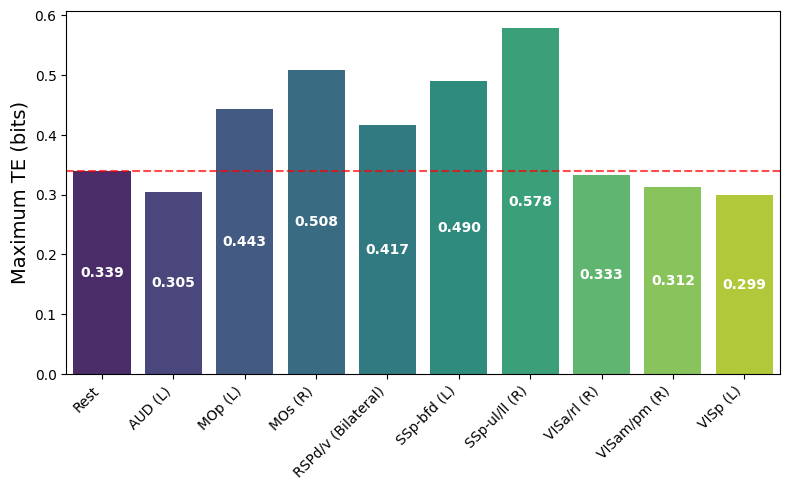

/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_39150/3198335877.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar


Group sizes: Counter({'Prefrontal': 1})
Group sizes: Counter({'Prefrontal': 1})
Group sizes: Counter({'Prefrontal': 1})
Group sizes: Counter({'Prefrontal': 1})
Group sizes: Counter({'Prefrontal': 1})
Group sizes: Counter({'Orbital': 1})
Group sizes: Counter({'Orbital': 1})
Group sizes: Counter({'Orbital': 1})
Group sizes: Counter({'Insular': 1})
Group sizes: Counter({'Insular': 1})
Group sizes: Counter({'Insular': 1})
Group sizes: Counter({'Gustatory': 1})
Group sizes: Counter({'Visual': 1})
Group sizes: Counter({'Temporal Assoc': 1})
Group sizes: Counter({'Temporal Assoc': 1})
Group sizes: Counter({'Temporal Assoc': 1})
Group sizes: Counter({'Somatosensory': 1})
Group sizes: Counter({'Somatosensory': 1})
Group sizes: Counter({'Somatosensory': 1})
Group sizes: Counter({'Somatosensory': 1})
Group sizes: Counter({'Somatosensory': 1})
Group sizes: Counter({'Somatosensory': 1})
Group sizes: Counter({'Somatosensory': 1})
Group sizes: Counter({'Somatosensory': 1})
Group sizes: Counter({'Moto

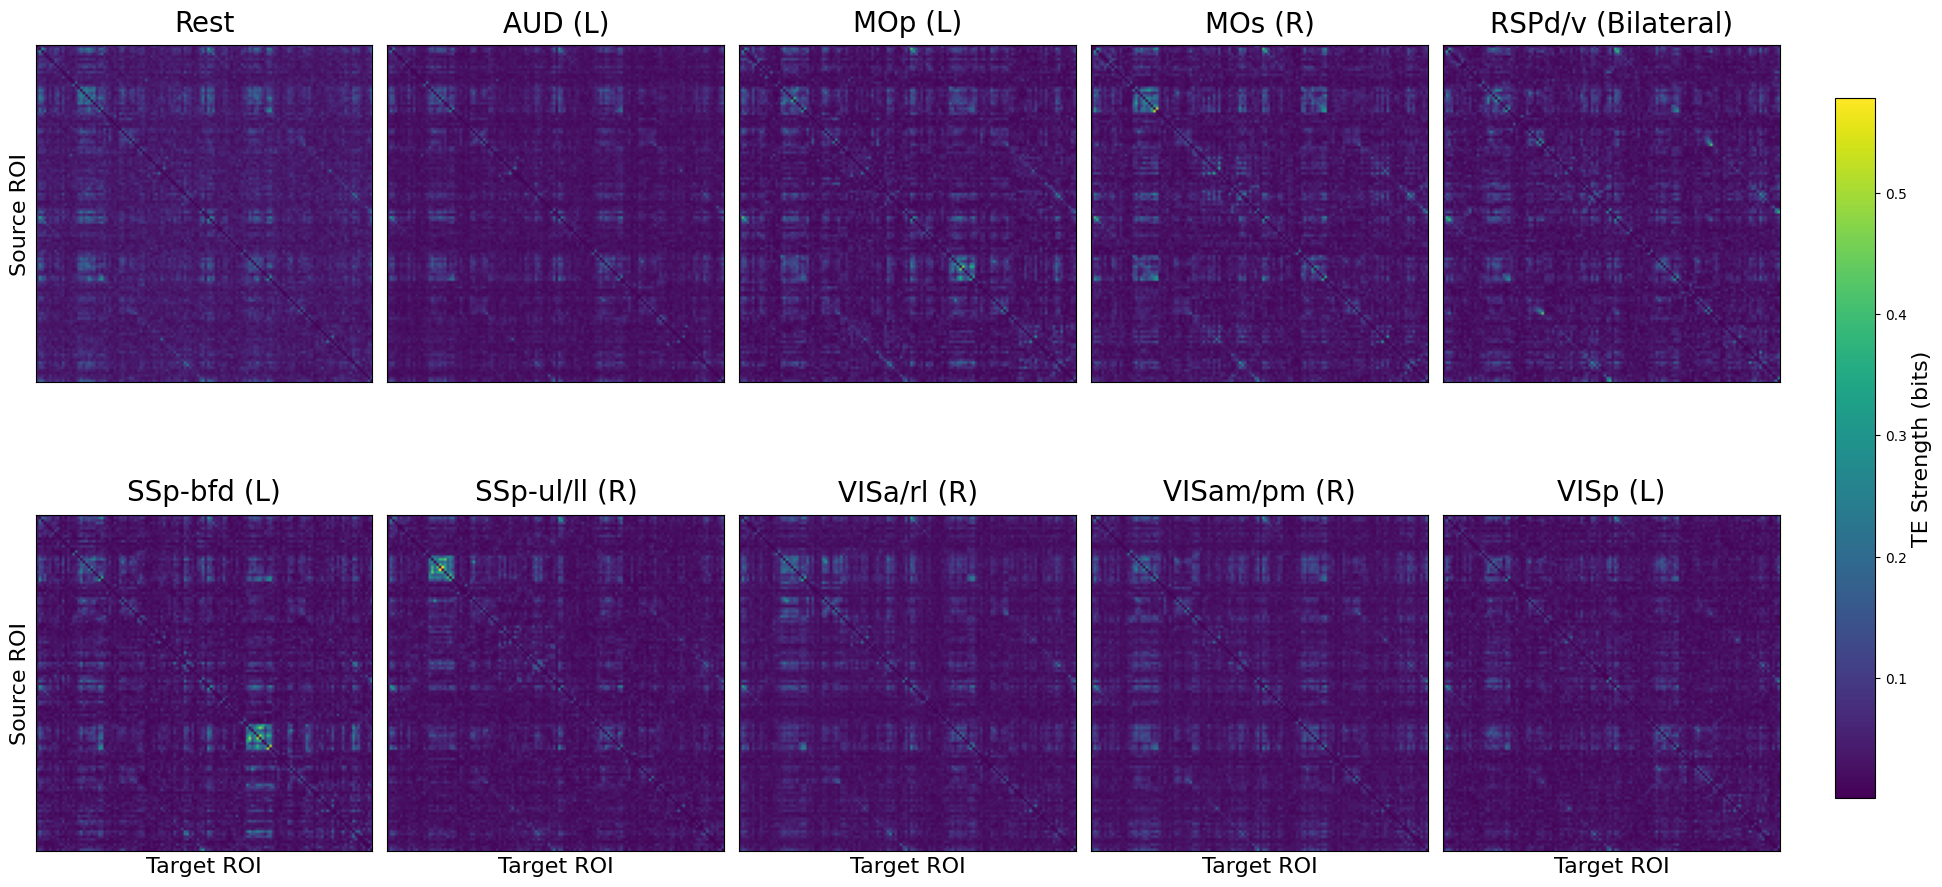

In [22]:
# Display plot and save to PDF
plot_te_heatmaps(results_folder='results', output_pdf='TE_heatmaps.pdf')

In [ ]:
def plot_system_connection_changes(results_folder='results', figsize=(5, 3), output_pdf=None):
    """
    Plot system-level TE connection changes for all conditions (vs Rest)
    with 5 subplots per row and optional PDF export
    
    Parameters:
        results_folder (str): Path containing .pkl result files
        figsize (tuple): Figure size dimensions
        output_pdf (str): Optional path to save PDF output
    """
    
    # Set global font sizes (larger than default)
    plt.rcParams.update({
        'axes.titlesize': 40,    # Title size for each subplot
        'axes.labelsize': 14,    # X and Y label sizes
        'xtick.labelsize': 13,   # X tick labels
        'ytick.labelsize': 15,   # Y tick labels
        'legend.fontsize': 16,   # Legend font size
        'figure.titlesize': 22   # Overall figure title size
    })
    
    # 1. Data loading and preprocessing
    result_files = sorted(glob.glob(os.path.join(results_folder, '*.pkl')))
    conditions = []
    system_changes = []
    roi_names = None
    rest_matrix = None
    
    # First load Rest condition data
    for filepath in result_files:
        if 'rest' in os.path.basename(filepath).lower():
            with open(filepath, 'rb') as f:
                data = pickle.load(f)
            roi_names = data['metadata']['roi_names']
            rest_matrix = np.zeros((len(roi_names), len(roi_names)))
            for cond_key in data['conditions']:
                for pair_data in data['conditions'][cond_key]['roi_pairs'].values():
                    if 'error' in pair_data:
                        continue
                    src, tgt = pair_data['roi_info']['indices']
                    rest_matrix[src, tgt] = pair_data.get('TE', {}).get('mean', 0)
            break
    
    if rest_matrix is None:
        raise ValueError("No Rest condition data found")
    
    # Get functional system groupings
    groups = auto_detect_groups(roi_names)
    unique_groups = sorted(set(groups.values()))
    group_indices = {g: [i for i, name in enumerate(roi_names) if groups[i] == g] for g in unique_groups}
    
    # 2. Calculate system-level changes for each condition
    for filepath in result_files:
        if 'rest' in os.path.basename(filepath).lower():
            continue
            
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        cond = data.get('metadata', {}).get('selected_conditions', os.path.basename(filepath))
        if isinstance(cond, list) and len(cond) == 1:
            cond = cond[0]
        
        # Build current condition matrix
        cond_matrix = np.zeros_like(rest_matrix)
        for cond_key in data['conditions']:
            for pair_data in data['conditions'][cond_key]['roi_pairs'].values():
                if 'error' in pair_data:
                    continue
                src, tgt = pair_data['roi_info']['indices']
                cond_matrix[src, tgt] = pair_data.get('TE', {}).get('mean', 0)
        
        # Calculate system-level changes (current - rest)
        system_change = np.zeros((len(unique_groups), len(unique_groups)))
        for i, src_group in enumerate(unique_groups):
            for j, tgt_group in enumerate(unique_groups):
                src_nodes = group_indices[src_group]
                tgt_nodes = group_indices[tgt_group]
                rest_conn = rest_matrix[np.ix_(src_nodes, tgt_nodes)]
                cond_conn = cond_matrix[np.ix_(src_nodes, tgt_nodes)]
                system_change[i, j] = np.sum(cond_conn - rest_conn)
        
        conditions.append(cond)
        system_changes.append(system_change)
    
    # 3. Calculate layout (3 subplots per row)
    n_conditions = len(conditions)
    n_cols = 3
    n_rows = int(np.ceil(n_conditions / n_cols))
    
    # Adjust figure size based on number of rows
    fig_height = 5 * n_rows 
    fig = plt.figure(figsize=(20, fig_height))
    
    # Determine global color scale (symmetric around zero)
    all_changes = np.concatenate([mat.flatten() for mat in system_changes])
    abs_max = np.max(np.abs(all_changes))
    vmin, vmax = -abs_max, abs_max
    
    # Colormap for bidirectional changes
    cmap = plt.cm.coolwarm
    
    # 4. Create subplot grid
    for idx, (cond, change_mat) in enumerate(zip(conditions, system_changes)):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        
        # Plot heatmap
        im = ax.imshow(change_mat, cmap=cmap, vmin=vmin, vmax=vmax)
        
        # Add system labels with larger font
        ax.set_xticks(np.arange(len(unique_groups)))
        ax.set_yticks(np.arange(len(unique_groups)))
        ax.set_xticklabels(unique_groups, rotation=45, ha='right', fontsize=12) 
        ax.set_yticklabels(unique_groups, fontsize=12) 
        
        # Mark stimulated system
        current_group = None
        for group in unique_groups:
            if group.lower() in cond.lower():
                current_group = group
                break
        
        if current_group:
            group_idx = unique_groups.index(current_group)
            ax.scatter(group_idx, group_idx, marker='*', s=150,
                      color='gold', edgecolor='black', label='Stimulated System')
            ax.legend(fontsize=10)
        
        ax.set_title(cond, pad=10, fontsize=14)
    
    # 5. Add shared colorbar with larger font
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('ΔTE Connection Strength (bits)', fontsize=14) 
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    
    # Save to PDF if output path specified
    if output_pdf:
        plt.savefig(output_pdf, format='pdf', bbox_inches='tight', dpi=300)
        print(f"PDF saved to: {output_pdf}")
    
    plt.show()

Group sizes: Counter({'Visual': 22, 'Somatosensory': 16, 'Thalamus': 16, 'Midbrain': 16, 'Prefrontal': 10, 'Auditory': 8, 'Orbital': 6, 'Insular': 6, 'Temporal Assoc': 6, 'Retrosplenial': 6, 'Motor': 4, 'Geniculate': 4, 'Basal Ganglia': 4, 'Gustatory': 2, 'Epithalamus': 2, 'Reticular': 2})


/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_39150/162990876.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make room for colorbar


PDF saved to: system_connection_changes.pdf


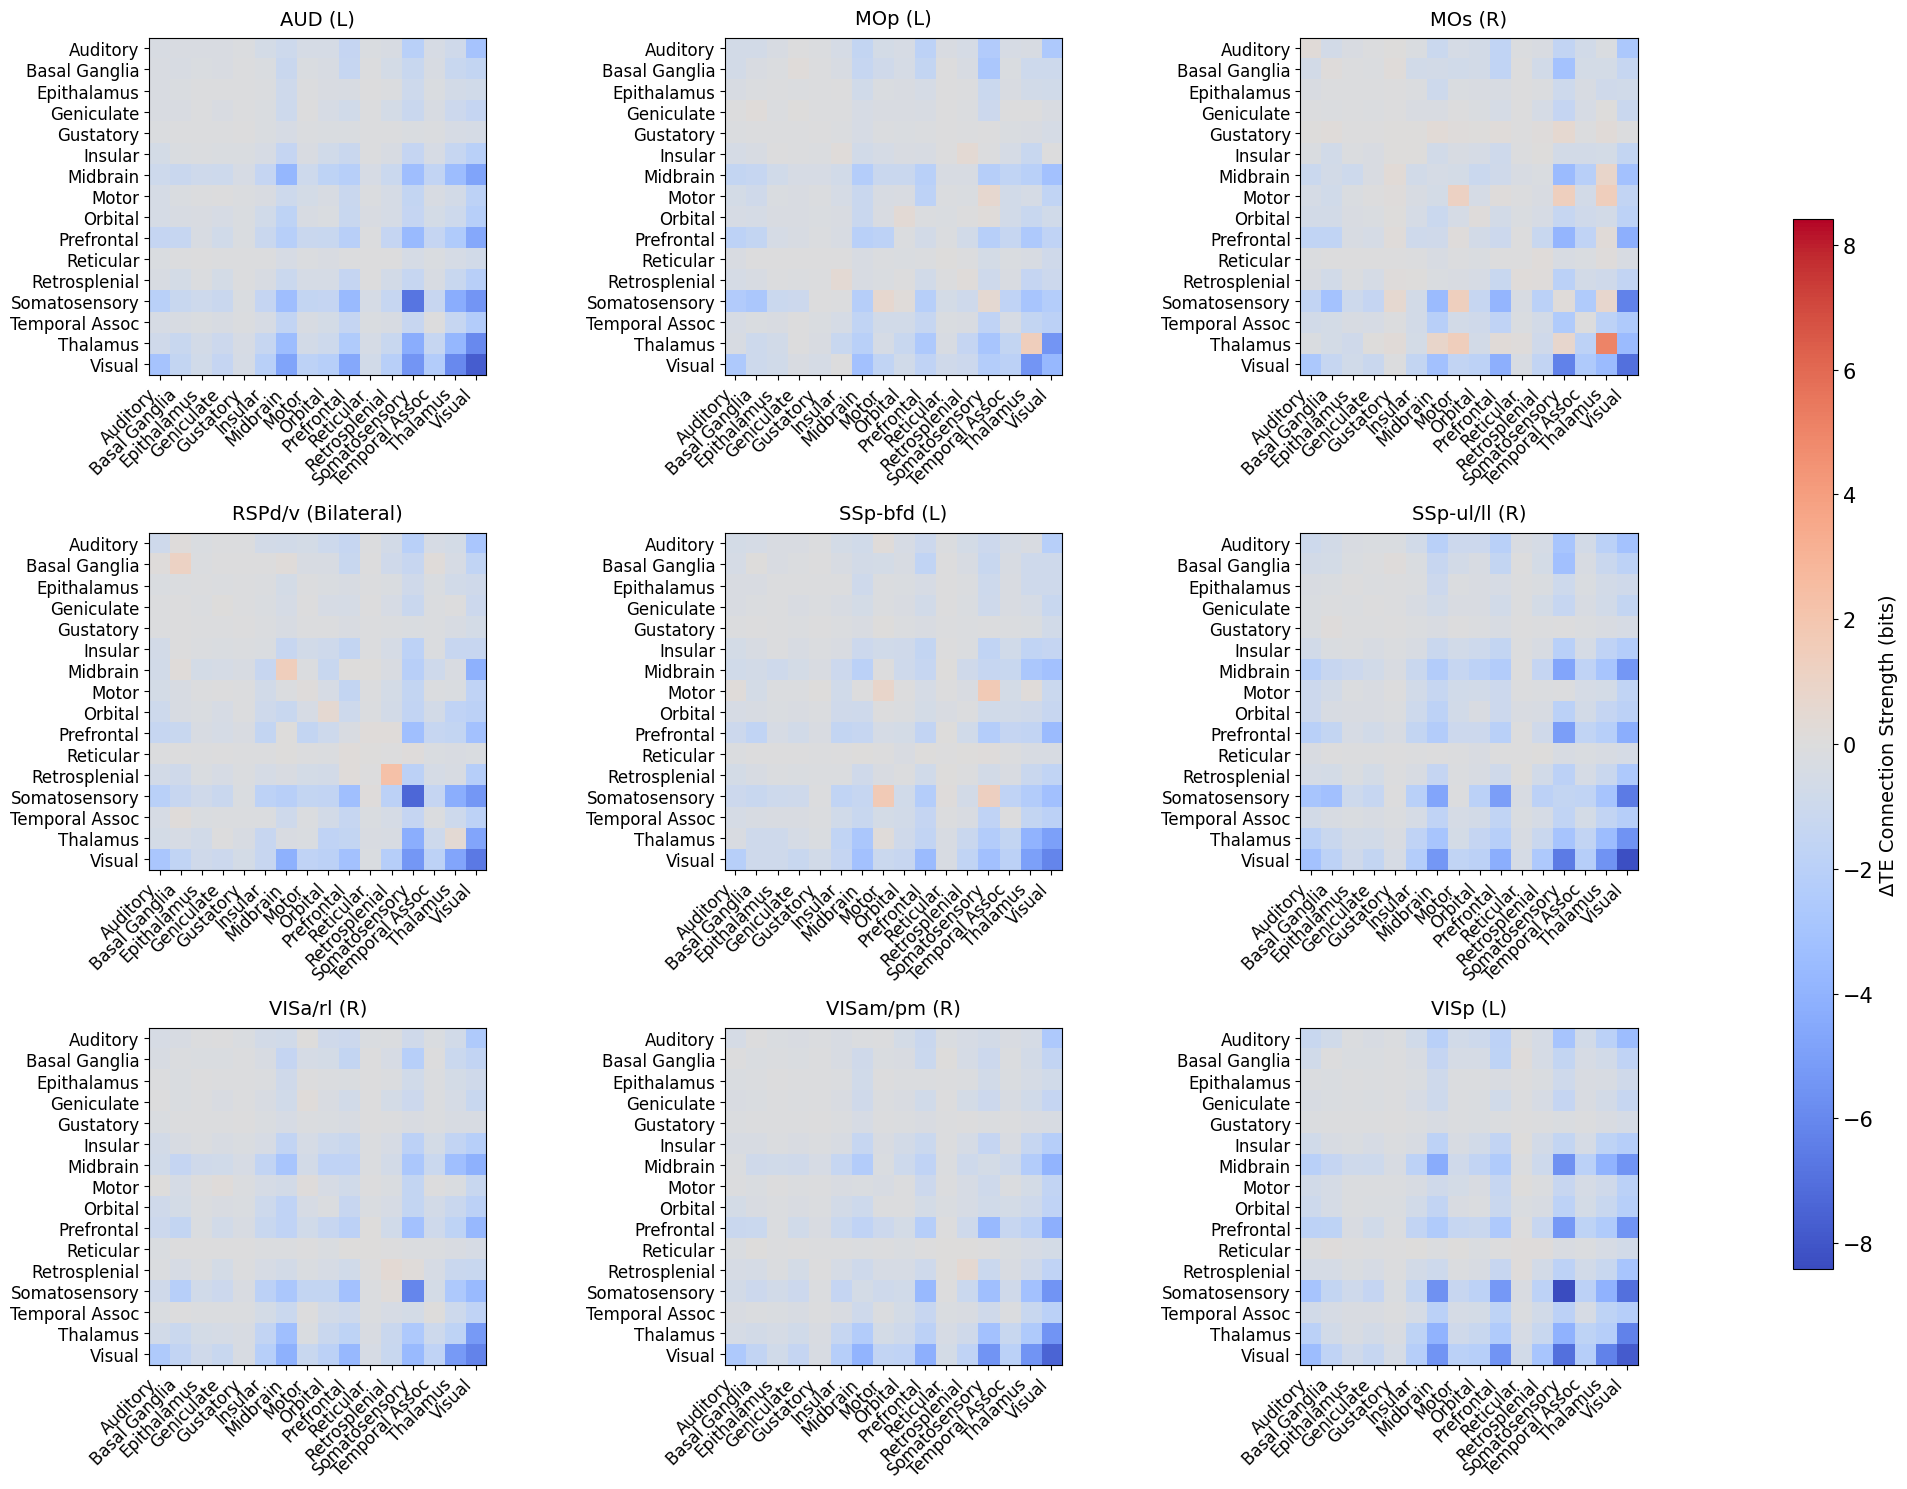

In [5]:
plot_system_connection_changes(results_folder='results', output_pdf='system_connection_changes.pdf')